Anchored Ensembling - Classification Example in Keras
=========

This notebook shows how Bayesian NN ensembles can be implemented for classfication in keras.

We show how it compares to other ensembling types, and also the effect of the prior.

If you're running this a few times, restarting the kernel helps to speed up (keras is not v good with many NNs floating around).



In [1]:
%matplotlib inline
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_blobs
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
# NN options
n_ensemble = 5	# no. NNs in ensemble
reg = 'anc'		# type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 50 	# no. hidden units in NN
activation_in = 'relu' # tanh relu sigmoid

# optimisation options
epochs = 50 		# run reg for 15+ epochs seems to mess them up
l_rate = 0.01 		# learning rate

# data options
n_data = 30 	# no. training data points
n_classes = 2 	# no. classes predicting
n_Xdim = 2 	# no. features for X
seed_in = 1 # random seed used to produce data blobs - try changing to see how results look w different data

# variance of priors
W1_var = 10/n_Xdim		# 1st layer weights and biases
W_mid_var = 1/n_hidden	# 2nd layer weights and biases
W_last_var = 1/n_hidden	# 3rd layer weights

In [3]:

def fn_make_data(n_samples=n_data, seed_in=0):
	# create some data
	x_train, y_train = make_blobs(n_samples=n_data, centers=n_classes, n_features=n_Xdim,random_state=seed_in)

	# normalise
	x_mu = np.mean(x_train)
	x_std = np.std(x_train)
	x_train = (x_train - x_mu)/x_std

	y_train = keras.utils.to_categorical(y_train, n_classes)

	x_test = x_train.copy()
	y_test = y_train.copy()

	return x_train, y_train, x_test, y_test

In [4]:
# NN loss
def fn_my_loss(y_true,y_pred):
	return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

# NN object
def fn_make_NN(reg='anc', activation_in='relu'):

	# get initialisations, and regularisation values
	W1_lambda = 1/(2*W1_var)
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_Xdim,n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_Xdim,n_hidden])

	b1_var = W1_var
	b1_lambda =  1/(2*b1_var)
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = 1/(2*W_mid_var)
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  1/(2*b1_var)
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = 1/(2*W_last_var)
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, n_classes])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, n_classes])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_Xdim,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))

	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))

	model.add(Dense(n_classes, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss=fn_my_loss, 
		optimizer=keras.optimizers.Adam(lr=l_rate),metrics=['accuracy'])

	return model


def fn_predict_ensemble(NNs, x_test):
	''' fn to predict given a list of NNs (an ensemble)''' 
	y_logit_preds = []
	for m in range(len(NNs)):
		y_logit_preds.append(NNs[m].predict(x_test, verbose=0))
	y_logit_preds = np.array(y_logit_preds)

	sess = tf.Session()
	y_prob_preds = sess.run(tf.nn.softmax(y_logit_preds))
	sess.close()

	y_prob_final = np.mean(y_prob_preds,axis=0)

	return y_logit_preds, y_prob_preds, y_prob_final

In [5]:

def fn_plot(NNs, render='cartoon', title='',size_in=(6,3), plot_range=(5,5)):
	''' render is either full or cartoon '''

	# set nice colours
	col_lookup = {0:'deepskyblue',1:'salmon',2:'g',3:'w',4:'o'} 
	color_in = []
	for i in range(y_train.shape[0]):
		for j in range(n_classes):
			if y_train[i,j] == 1:
				color_in.append(col_lookup[j])

	# make a grid to plot over
	x_range = plot_range[0]
	y_range = plot_range[0]
	x = np.linspace(-x_range,x_range,50+1)
	y = np.linspace(-y_range,y_range,50+1)
	x_grid_row,x_grid_col = np.meshgrid(x,y)
	x_grid = np.vstack([x_grid_row.ravel(), x_grid_col.ravel()]).T

	# do predictions over whole grid
	y_logit_preds, y_prob_preds, y_prob_final = fn_predict_ensemble(NNs,x_grid)
	y_prob_final_grid = y_prob_final[:,0].reshape(x_grid_row.shape)

	fig = plt.figure(figsize=size_in)
	ax = fig.add_subplot(111)
    
	# fix for the white lines between contour levels
	if render == 'cartoon':
		cnt = ax.contourf(x_grid_row, x_grid_col, y_prob_final_grid, 
                          levels=[0.,0.02,0.1,0.3,0.4,0.6,0.7,0.9,0.98,1.0], cmap='RdBu')
	elif render == 'full':
		cnt = ax.contourf(x_grid_row, x_grid_col, y_prob_final_grid, levels=500, cmap='RdBu')
	for c in cnt.collections:
		c.set_edgecolor("face")

	ax.scatter(x_train[:,0],x_train[:,1],c=color_in, s=50,linewidths=1,edgecolors='k')
	ax.set_title(title)
	fig.show()

	return


In [6]:
# create some data
x_train, y_train, x_test, y_test = fn_make_data(seed_in=seed_in)

# create the NNs
NNs=[]
for m in range(n_ensemble):
	NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
print(NNs[-1].summary())

# do the actual training
NNs_hist_train=[]; NNs_hist_val=[]
for m in range(n_ensemble):
	print('\n\n-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs[m].fit(x_train, y_train,
			  batch_size=n_data,
			  epochs=epochs,
			  verbose=0,
			  validation_data=(x_test, y_test))
	NNs_hist_train.append(hist.history['loss'])
	NNs_hist_val.append(hist.history['val_loss'])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 100       
Total params: 2,800
Trainable params: 2,800
Non-trainable params: 0
_________________________________________________________________
None


-- training: 1 of 5 NNs --


-- training: 2 of 5 NNs --


-- training: 3 of 5 NNs --


-- training: 4 of 5 NNs --


-- training: 5 of 5 NNs --


In [7]:
# evaluate accuracy on test set (in this e.g. x_test=x_train)
y_logit_preds, y_prob_preds, y_prob_final = fn_predict_ensemble(NNs,x_test)

# evaluate accuracy for individual NNs
for m in range(n_ensemble): # individual members
    score = NNs[m].evaluate(x_test, y_test, verbose=0)
    print('NN ' + str(m) + ' test accuracy:', np.round(score[1],3))

# accuract for whole ensemble
ens_acc = np.mean(np.equal(np.argmax(y_prob_final,axis=-1), np.argmax(y_test,axis=-1)))
print('total ens test accuracy:', np.round(ens_acc,3))

NN 0 test accuracy: 1.0
NN 1 test accuracy: 1.0
NN 2 test accuracy: 1.0
NN 3 test accuracy: 1.0
NN 4 test accuracy: 1.0
total ens test accuracy: 1.0


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


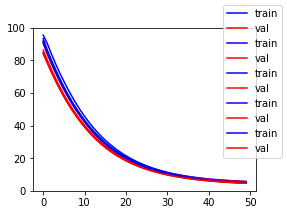

In [8]:
# check how training looked
NNs_hist_train=np.array(NNs_hist_train)
NNs_hist_val=np.array(NNs_hist_val)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
for m in range(n_ensemble):
    ax.plot(NNs_hist_train[m], color='b',label='train')
    ax.plot(NNs_hist_val[m], color='r',label='val')
fig.legend(loc='upper right')
fig.show()

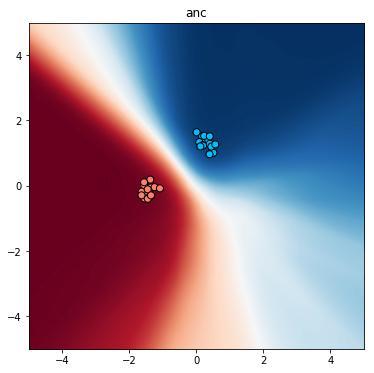

In [9]:
fn_plot(NNs, render='full',title=reg,size_in=(6,6))

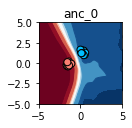

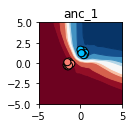

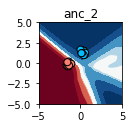

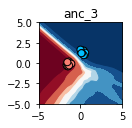

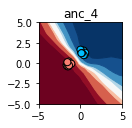

In [10]:
# it's interesting to inspect each indvidual NN's plot
for m in range(n_ensemble):
    list_=[]
    list_.append(NNs[m])
    fn_plot(list_, render='cartoon',title=reg + '_' + str(m),size_in=(1.5,1.5))

-- reg: free --
-- training: 1 of 5 NNs --
-- training: 2 of 5 NNs --
-- training: 3 of 5 NNs --
-- training: 4 of 5 NNs --
-- training: 5 of 5 NNs --
-- reg: reg --
-- training: 1 of 5 NNs --
-- training: 2 of 5 NNs --
-- training: 3 of 5 NNs --
-- training: 4 of 5 NNs --
-- training: 5 of 5 NNs --
-- reg: anc --
-- training: 1 of 5 NNs --
-- training: 2 of 5 NNs --
-- training: 3 of 5 NNs --
-- training: 4 of 5 NNs --
-- training: 5 of 5 NNs --


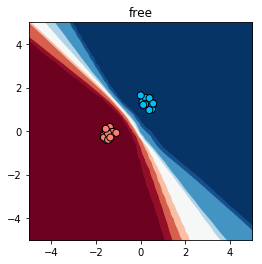

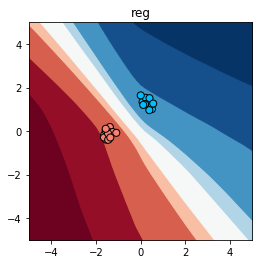

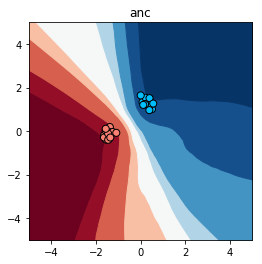

In [11]:
# do comparison for all ensemble methods
for reg in ['free','reg','anc']:
    print('-- reg: ' + reg + ' --')
    
    # create the NNs
    NNs=[]
    for m in range(n_ensemble):
        NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

    # training
    for m in range(n_ensemble):
        print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
        hist = NNs[m].fit(x_train, y_train,
                  batch_size=n_data,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(x_test, y_test))

    fn_plot(NNs, render='cartoon',title=reg,size_in=(4,4))

-- training: 1 of 5 NNs --
-- training: 2 of 5 NNs --
-- training: 3 of 5 NNs --
-- training: 4 of 5 NNs --
-- training: 5 of 5 NNs --
-- training: 1 of 5 NNs --
-- training: 2 of 5 NNs --
-- training: 3 of 5 NNs --
-- training: 4 of 5 NNs --
-- training: 5 of 5 NNs --


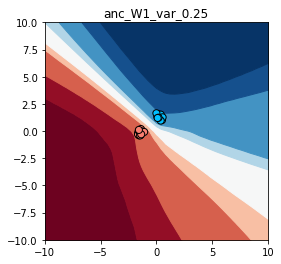

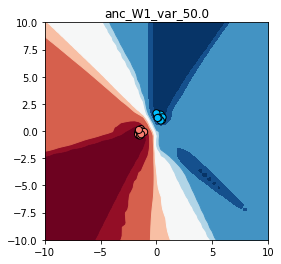

In [12]:
# see effect of prior - lower variance makes smoother functions
reg='anc'
for W1_var_in in [0.5,100]:
    W1_var = W1_var_in/n_Xdim
    
    # create the NNs
    NNs=[]
    for m in range(n_ensemble):
        NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))

    # training
    for m in range(n_ensemble):
        print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
        hist = NNs[m].fit(x_train, y_train,
                  batch_size=n_data,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(x_test, y_test))

    fn_plot(NNs, render='cartoon',title=reg + '_W1_var_' + str(W1_var),size_in=(4,4),plot_range=(10,10))